# SVM For Jellyfish Classification 💙

> Names - IDs
- Reema Bahamdain - 2009525
- Noof Patwa - 2111058

Import necessary libraries 💡

In [5]:
from google.colab import files
import zipfile
import os
import cv2
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.image as mpimg

Upload and Load the Dataset 📥

In [6]:
# Unzip the dataset
# A list containing the paths to the zip files
zip_paths = ["/content/barrel_images_temp.zip", "/content/lions_images_temp.zip"]

# Unzipping each file in the list
for zip_path in zip_paths:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/dataset")

Display images from each class 📸

Class: lions_images_temp


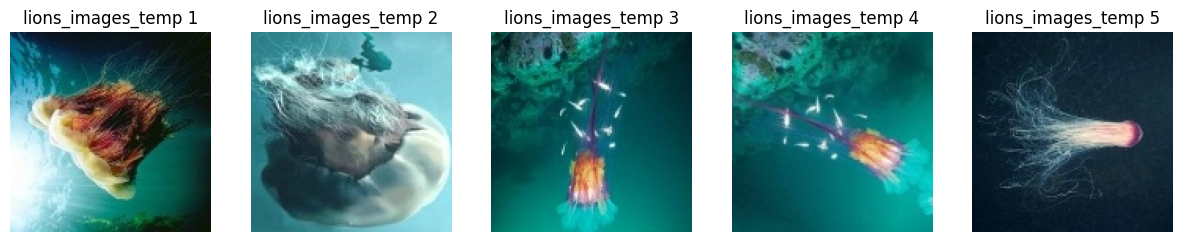

Class: barrel_images_temp


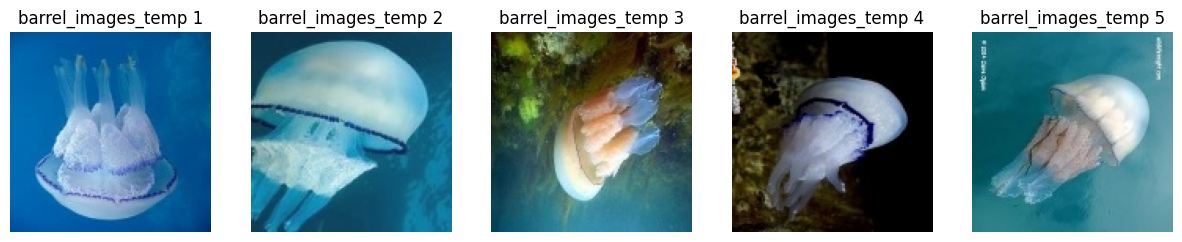

In [7]:
# Path to the main dataset folder
dataset_path = "/content/dataset"

# Get a list of classes (subdirectories)
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Display the first 5 images from each class
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))][:5]

    print(f"Class: {class_name}")

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{class_name} {i+1}")
        plt.axis('off')
    plt.show()

Feature Extraction Using HOG 💥

In [8]:
# Function to extract HOG features
def extract_hog_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    # Resize the image to 64x64
    image = cv2.resize(image, (64, 64))
    # Extract HOG features
    hog_features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_features

# Prepare the dataset
data_dir = "/content/dataset"
hog_features_list = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if not os.path.isdir(label_dir):
        continue
    for file in os.listdir(label_dir):
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(label_dir, file)
            hog_features = extract_hog_features(img_path)
            if hog_features is not None:  # Ensure features were extracted
                hog_features_list.append(hog_features)
                labels.append(label)

# Convert to NumPy arrays
X_hog = np.array(hog_features_list)
y = np.array(labels)

Divide the Dataset Into Training & Testing
🗂️

In [9]:
# Split into training and testing sets
X_hog_train, X_hog_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=42)

Model Training 💻

In [10]:
# Perform Grid Search for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_hog_train, y_train)

# Best hyperparameters and model
best_svm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Model Performance Testing 💯

In [11]:
# Evaluate the best model
y_pred_hog_svm = best_svm.predict(X_hog_test)

Classification report 📝

In [12]:
# Print the classification report
print("HOG + SVM Classification Report (Best Model):")
print(classification_report(y_test, y_pred_hog_svm))

HOG + SVM Classification Report (Best Model):
                    precision    recall  f1-score   support

barrel_images_temp       0.90      0.83      0.86       104
 lions_images_temp       0.83      0.90      0.86        96

          accuracy                           0.86       200
         macro avg       0.86      0.86      0.86       200
      weighted avg       0.86      0.86      0.86       200



Confusion Matrix 🧮

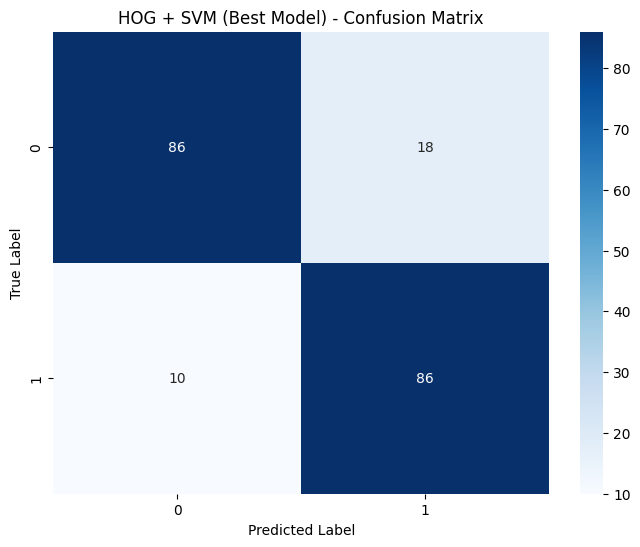

In [13]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred_hog_svm, "HOG + SVM (Best Model)")

Training and Testing Accuracies Plot 📉

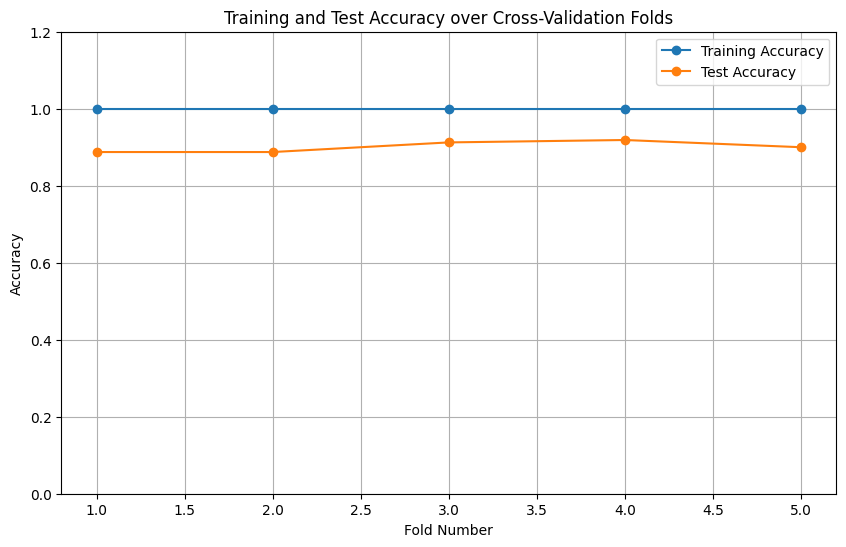

In [16]:
# Track Training and Testing Accuracies
train_accuracies = []
test_accuracies = []

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train the model on each fold during cross-validation to track accuracy
for train_index, test_index in kf.split(X_hog_train):
    X_fold_train, X_fold_test = X_hog_train[train_index], X_hog_train[test_index]
    y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

    # Train with best parameters
    svm_model = SVC(**grid_search.best_params_)
    svm_model.fit(X_fold_train, y_fold_train)

    # Calculate accuracies
    train_accuracy = svm_model.score(X_fold_train, y_fold_train)
    test_accuracy = svm_model.score(X_fold_test, y_fold_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-', label='Test Accuracy')

# Set Y-axis ticks to range from 0 to 1.3 with a step of 0.2
# We set the y dimention (accurecy) to 1.3 just to showing the lines clearly
plt.yticks(np.arange(0, 1.3, 0.2))

# Add titles and labels
plt.title('Training and Test Accuracy over Cross-Validation Folds')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()